# Real State

Cargamos las librerías necesarias:

In [1]:
from io import StringIO
from IPython.display import Image
import matplotlib as mpl
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydotplus
import seaborn as sns
from sklearn import svm
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz

%matplotlib inline

import pydot
from IPython.display import Image
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor

Utilizaremos un conjunto de datos público de precios de viviendas en Taiwán con el objetivo de encontrar las mejores ofertas del mercado. La descripción completa del conjunto de datos la podemos encontrar en el siguiente enlace:
 https://archive.ics.uci.edu/ml/datasets/Real+estate+valuation+data+set

Empezamos cargando los datos en un DataFrame de pandas:

In [2]:
dataset = pd.read_excel('Real estate valuation data set.xlsx', engine='openpyxl')

dataset.head()

No  X1 transaction date  X2 house age  \
0   1          2012.916667          32.0   
1   2          2012.916667          19.5   
2   3          2013.583333          13.3   
3   4          2013.500000          13.3   
4   5          2012.833333           5.0   

   X3 distance to the nearest MRT station  X4 number of convenience stores  \
0                                84.87882                               10   
1                               306.59470                                9   
2                               561.98450                                5   
3                               561.98450                                5   
4                               390.56840                                5   

   X5 latitude  X6 longitude  Y house price of unit area  
0     24.98298     121.54024                        37.9  
1     24.98034     121.53951                        42.2  
2     24.98746     121.54391                        47.3  
3     24.98746     121.54391                        54.8  
4     24.97937     121.54245                        43.1

La primera columna ("*No*") es un identificador numérico de la muestra. Las columnas "*Xn...*" son los distintos atributos descriptivos. Por último, la columna "*Y ...*" es el valor objetivo o precio de la vivienda.

Extraemos de *DataFrame* la variable objetivo y los atributos descriptivos que utilizaremos posteriormente al modelo predictivo:

In [3]:
X = dataset[[
    'X2 house age',
    'X3 distance to the nearest MRT station',
    'X4 number of convenience stores',
    'X5 latitude',
    'X6 longitude'
]]

y = dataset['Y house price of unit area']

### Análisis descriptivo

<div class="alert alert-block alert-info">
Analizaremos gráficamente la distribución de todas las variables (features y target).
</div>

Dependiendo de la interpretación podríamos considerar algunas variables como categóricas o numéricas, como por ejemplo el número de tiendas cercanas. Pero también podría considerarse como una variable numérica. En nuestro caso, viendo los valores de los datos, los consideraremos todos numéricos.

Antes de analizar gráficamente los datos, veremos la dimensión del dataset y ejecutaremos la función *describe()* para tener algo más de información:

In [4]:
X.shape

(414, 5)

In [5]:
X.describe()

X2 house age  X3 distance to the nearest MRT station  \
count    414.000000                              414.000000   
mean      17.712560                             1083.885689   
std       11.392485                             1262.109595   
min        0.000000                               23.382840   
25%        9.025000                              289.324800   
50%       16.100000                              492.231300   
75%       28.150000                             1454.279000   
max       43.800000                             6488.021000   

       X4 number of convenience stores  X5 latitude  X6 longitude  
count                       414.000000   414.000000    414.000000  
mean                          4.094203    24.969030    121.533361  
std                           2.945562     0.012410      0.015347  
min                           0.000000    24.932070    121.473530  
25%                           1.000000    24.963000    121.528085  
50%                           4.000000    24.971100    121.538630  
75%                           6.000000    24.977455    121.543305  
max                          10.000000    25.014590    121.566270

El dataset tiene 414 filas y 5 columnas.

De estas 5 columnas podemos ver su promedio, desviación estándar, su distribución, mínimo y máximo valor. Destaca el valor 0 en el mínimo de años y tiendas cercanas. En la página del dataset no específica si éstos son valores que indican que no se conoce el valor o son valores reales. Asumiremos que son valores reales, 0 en *X2 house age* indicará que la casa será muy nueva y 0 en *X4 number of convenience stores*, que efectivamente, no hay tiendas cercanas a la vivienda.

Vemos lo mismo pero con la variable objetivo:

In [6]:
y.shape

(414,)

In [7]:
y.describe()

count    414.000000
mean      37.980193
std       13.606488
min        7.600000
25%       27.700000
50%       38.450000
75%       46.600000
max      117.500000
Name: Y house price of unit area, dtype: float64

Pasamos ya al análisis visual. Como se consideran todos los datos numéricos, las visualizaciones serán histogramas.

**X2 house age**

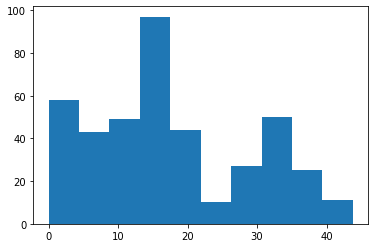

In [8]:
plt.hist(X["X2 house age"])
plt.show()

Los años más frecuentes que tienen las viviendas del dataset son unos 15. Una parte importante de las casas tienen entre 0 y 20 años. Entre 25 y 50 años tenemos menos casas pero una parte nada desdeñable del dataset.

**X3 distance to the nearest MRT station**

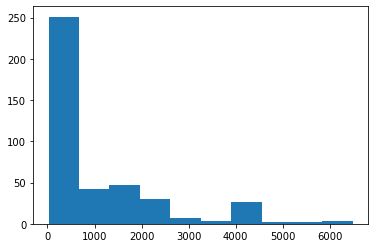

In [9]:
plt.hist(X["X3 distance to the nearest MRT station"])
plt.show()

Aquí sí que vemos que la gran mayoría de datos se encuentran a una distancia de entre 0 y 1000 metros de distancia de una estación MRT. Esto significa que la mayoría de casas de dataset no están muy aisladas.

**X4 number of convenience stores**

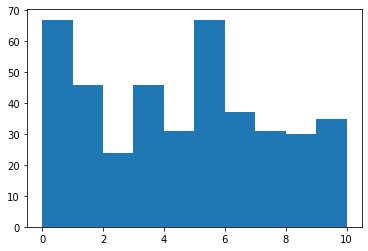

In [10]:
plt.hist(X["X4 number of convenience stores"])
plt.show()

A diferencia del anterior atributo, aquí no tenemos ningún valor que acapare la mayoría de las instancias. Podrían destacar tener entre 0 y 1 y entre 5 y 6 tiendas cercanas, pero los demás valores están bastante cerca.

**X5 latitude**

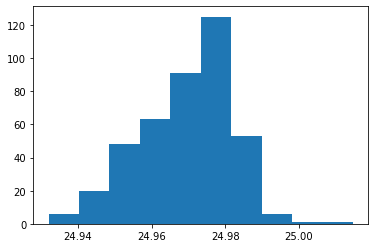

In [11]:
plt.hist(X["X5 latitude"])
plt.show()

**X6 longitude**

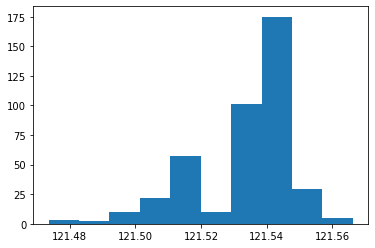

In [12]:
plt.hist(X["X6 longitude"])
plt.show()

Latitud y longitud podemos considerarlas juntos, puesto que tiene más sentido que analizar cada una por separado. Los rangos de las dos son pequeños y destacan unos valores frente a otros. Es decir, la zona de la que tenemos los datos no será excesivamente extensa. Leyendo la descripción del dataset en su página, vemos que corresponden al distrito Sindian de la ciudad New Taipei de Taiwán.

**Y house price of unit area**

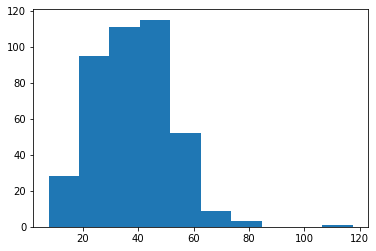

In [13]:
plt.hist(y)
plt.show()

Por último, vemos visualmente la distribución de los precios. Como hemos visto en la página del dataset, el formato de estas variables es New Taiwan Dollar/Ping. La mayoría de los datos están en los valores 20-50.

### Preprocesamiento de los datos

Una vez realizado un primer análisis, se trata de "limpiar" el dataset (las features) y adaptarlo a nuestras necesidades (en este caso, predecir el precio de una vivienda).

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> Comprueba si hay null values. En caso de existir, elimina las filas correspondientes.
</div>

Para comprobar si tenemos valores nulos utilizaremos el mismo procedimiento realizado en la PAC 1. Utilizaremos las funciones *sum()* y *isnull()*.

In [14]:
X.isnull().sum()

X2 house age                              0
X3 distance to the nearest MRT station    0
X4 number of convenience stores           0
X5 latitude                               0
X6 longitude                              0
dtype: int64

In [15]:
y.isnull().sum()

0

No tenemos ningún valor nulo en nuestro dataset. Ni en el conjunto de características ni en el de los datos objetivo.

<div class="alert alert-block alert-info">
Vamos a mostrar la correlación entre todas las features numéricas. Si existen dos con una correlación superior al 90%, eliminaremos una de las dos.</div>

En primer lugar, calcularemos la matriz de correlaciones de los datos.

In [16]:
matriu_correlacions = X.corr()
matriu_correlacions

X2 house age  \
X2 house age                                1.000000   
X3 distance to the nearest MRT station      0.025622   
X4 number of convenience stores             0.049593   
X5 latitude                                 0.054420   
X6 longitude                               -0.048520   

                                        X3 distance to the nearest MRT station  \
X2 house age                                                          0.025622   
X3 distance to the nearest MRT station                                1.000000   
X4 number of convenience stores                                      -0.602519   
X5 latitude                                                          -0.591067   
X6 longitude                                                         -0.806317   

                                        X4 number of convenience stores  \
X2 house age                                                   0.049593   
X3 distance to the nearest MRT station                        -0.602519   
X4 number of convenience stores                                1.000000   
X5 latitude                                                    0.444143   
X6 longitude                                                   0.449099   

                                        X5 latitude  X6 longitude  
X2 house age                               0.054420     -0.048520  
X3 distance to the nearest MRT station    -0.591067     -0.806317  
X4 number of convenience stores            0.444143      0.449099  
X5 latitude                                1.000000      0.412924  
X6 longitude                               0.412924      1.000000

Y lo visualizamos con un *heatmap*:

<AxesSubplot:>

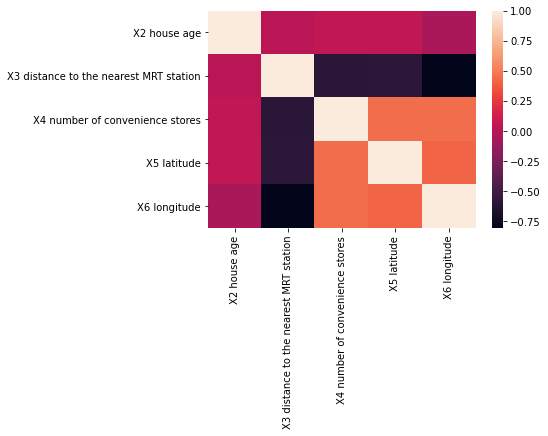

In [17]:
sns.heatmap(matriu_correlacions)

<div class="alert alert-block alert-info">
Realizamos varios scatterplots cruzando los distintos atributos con la variable target.
</div>

**X2 house age**

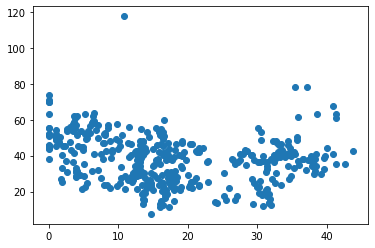

In [18]:
plt.scatter(X['X2 house age'], y)

**X3 distance to the nearest MRT station**

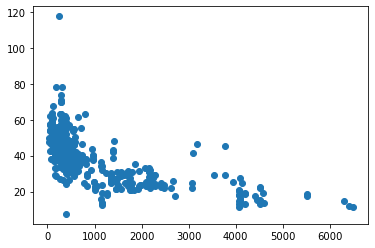

In [19]:
plt.scatter(X['X3 distance to the nearest MRT station'], y)

**X4 number of convenience stores**

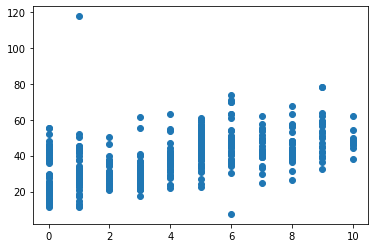

In [20]:
plt.scatter(X['X4 number of convenience stores'], y)

**X5 latitude**

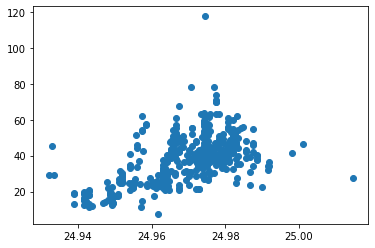

In [21]:
plt.scatter(X['X5 latitude'], y)

**X6 longitude**

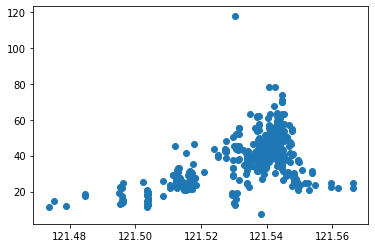

In [22]:
plt.scatter(X['X6 longitude'], y)

<div class="alert alert-block alert-info">
<strong>Análisis:</strong>
</div>

No existe ninguna correlación que supere el 90% (no tenemos en cuenta la diagonal, ya que es la correlación entre los atributos consigo mismos). Sí que podemos destacar la variable X3, la que corresponde a la distancia de la vivienda a una estación MRT. Esta variable está relacionada inversamente, con cierta importancia, con el número de tiendas cercanas, la latitud y longitud. Es decir, a mayor distancia a una estación MRT, menor número de tiendas cercanas. Parece lógico, ya que si hay una estación de metro, el sitio estará mejor comunicada, habrá más actividad en la zona y por tanto, más tiendas. En cuanto a la latitud y longitud, disminuirán si aumenta la distancia a las estaciones de metro. Supongamos que en menores latitudes y longitudes serán zonas del distrito más aisladas.

También podemos ver una relación positiva entre el número de tiendas con latitud y longitud. Supondremos que a valores más altos de latitud y longitud corresponderán zonas más céntricas de la ciudad y allí es donde habrá más tiendas.

En cuanto a los atributos donde la correlación no es significativa, tenemos la antigüedad de la vivienda con el resto de atributos. No parece haber relación entre las demás características y la antigüedad.

En cuanto a los *scatters plots*, analicémoslos uno por uno:
- **X2 house age:** Los precios por m2 están distribuidos de forma bastante uniforme. No existe un grupo de instancias con cierta antigüedad que destaque por tener un precio concreto.


- **X3 distance to the nearest MRT station:** Aquí sí que parecemos tener cierta relación. Cuanto menor es la distancia a una estación, mayor es el precio. Es lógico, puesto que si la zona está bien comunicada añade un valor extra a la vivienda.


- **X4 number of convenience stores:** Aquí ocurre semejante con la antigüedad. La distribución de precios según el número de tiendas cercanas es bastante uniforme.


- **X5 latitude i X6 longitude:** Tratamos estas gráficas conjuntamente, ya que latitud y longitud son características que suelen utilizarse conjuntamente. Los gráficos son muy parecidos, existe un grupo de datos con un precio más elevado en unas determinadas latitudes y longitudes. Es posible que estos puntos de latitud y longitud correspondan al centro de la ciudad o alguna zona más cara.

### Entrenamiento del modelo

Ahora que ya tenemos el dataset limpio y hemos realizado un análisis de las diferentes variables, podemos proceder a entrenar un modelo para predecir el precio de una vivienda.

<div class="alert alert-block alert-info">
Para empezar dividiremos el <i>dataset</i> en dos subconjuntos, <i>train</i> (80% de les dades) y <i>test</i> (20% de los datos).</div>

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

<div class="alert alert-block alert-info">
Utilizaremos un árbol de decisión simple con max_depth=5 para acotar el dataset sobre el conjunto de train. Dibujaremos el árbol de decisión (si te queda muy grande dibújalo de un árbol entrenado con menos profundidad para que se aprecie bien). Utilizaremos alguna medida de error para estimar lo bien que lo ha hecho el modelo prediciendo en train y en test. También nos servirá para comparar a posterior con otro modelo.</div>

Como es un árbol de regresión utilizaremos *DecisionTreeRegressor* de sklearn:

In [24]:
tree = DecisionTreeRegressor(max_depth=5, random_state=123)
tree.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=5, random_state=123)

Para este punto utilizaremos *graphviz*. Crearemos el árbol en formato .dot y después pasaremos la imagen a PNG y la visualizaremos con la función *Image()* de *IPython*.

Creamos la imagen y la guardamos con el nombre *tree.dot*:

In [25]:
export_graphviz(tree,
                     out_file="tree.dot",
                     feature_names = X.columns, 
                     class_names=['Y house price of unit area'],
                     filled = True)

Pasamos el archivo .dot a .png con la ayuda de la librería *pydot*:

In [26]:
(graph,) = pydot.graph_from_dot_file('tree.dot')
graph.write_png('tree.png')

Veiem l'arbre:

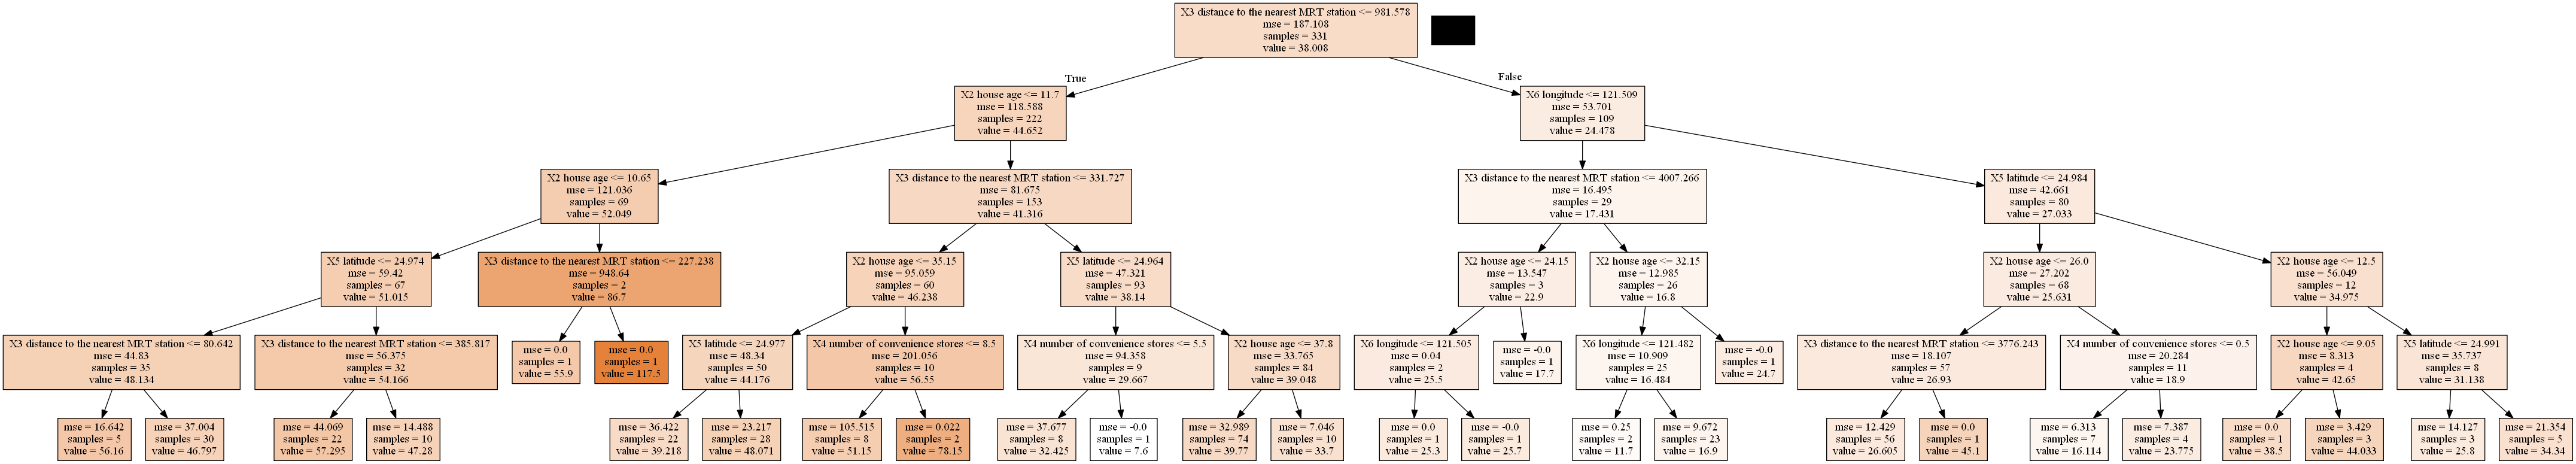

In [27]:
Image("tree.png")

Vemos también las variables más importantes a la hora de tomar decisiones:

In [28]:
list(zip(X.columns,tree.feature_importances_))

[('X2 house age', 0.19917248853301323),
 ('X3 distance to the nearest MRT station', 0.6660550541747218),
 ('X4 number of convenience stores', 0.0349220279176412),
 ('X5 latitude', 0.06214724795436101),
 ('X6 longitude', 0.03770318142026286)]

Pasamos ahora a evaluar el modelo. Prediremos con los datos de entrenamiento y test y utilizaremos la medida MAE para comparar los resultados. Esta medida calcula la media de los valores absolutos de los errores de predicción, es decir nos dice el tamaño del error medio del conjunto de datos. También utilizaremos la métrica *r_squared* para ver lo bien que se ajusta el modelo a los datos.

Al calcular el error con los datos de entrenamiento y test podremos ver si ha habido *overfitting*.

**Datos de entrenamiento**

In [29]:
y_pred = tree.predict(X_train)

In [30]:
MAE = mean_absolute_error(y_train, y_pred)
MAE

3.838578625315785

In [31]:
R2 = r2_score(y_train, y_pred)
R2

0.861649297532368

**Datos de test**

In [32]:
y_pred = tree.predict(X_test)

In [33]:
MAE = mean_absolute_error(y_test, y_pred)
MAE

6.532101117703529

In [34]:
R2 = r2_score(y_test, y_pred)
R2

-0.00960945911375033

<div class="alert alert-block alert-info">
<strong>Análisis:</strong>
</div>

Empecemos analizando la visualización del árbol. Como hemos visto con el parámetro *feature importances*, tenemos estos pesos en las variables:
- **X2 house age:** 0.19917249

- **X3 distance to the nearest MRT station:** 0.66605505

- **X4 number of convenience stores:** 0.03492203

- **X5 latitude:** 0.06214725

- **X6 longitude:** 0.03770318

Podemos ver que la variable más importante es la distancia a una estación metro. Es algo que ya podíamos intuir en el *scatter plot*, ya que parecía haber cierta relación entre los precios más elevados y la proximidad a una estación.

Otro atributo con cierta importancia es la antigüedad de la casa. En el mismo árbol podemos ver que después de la división del nodo raíz, de confirmarse que la casa tiene una estación a distancia menor igual de 981.578 metros, la siguiente división es si tiene más o menos de 11.7 años.

Una vez creado el modelo lo hemos evaluado mediante la medida MAE y R2. En el conjunto de entrenamiento hemos visto que teníamos un error absoluto medio de 3.83 New Taiwán Dollar/Ping y un R2 de 0.83, es decir, el modelo es capaz de explicar el 83% de los datos de entrenamiento. En cuanto a la evaluación de los datos de test, no hemos obtenido tan buen resultado. En cuanto al error medio, hemos obtenido casi el doble, un error de 6.53 New Taiwan Dollar/Ping y un R2 negativo. Este R2 significa que para los datos de test el modelo no se ajusta bien, tiene peor eficacia que un modelo arbitrario.

Este incremento en el error medio y el resultado en R2 significa que se ha producido overfitting. El modelo se ajusta muy bien a los datos de entrenamiento, pero no a otros que no se han utilizado para su construcción.

Para intentar corregir este *overfitting* podríamos, por ejemplo, ajustar algunos de los parámetros que nos proporciona sklearn como *min_samples_leaf*, que especifica un número mínimo de hojas para dividir el nodo. En la visualización podemos ver que tenemos algunas hojas que están representando un solo caso, esto podría también estar indicándonos este *overfitting*.

<div class="alert alert-block alert-info">
Ahora haremos lo mismo, pero implementaremos un modelo con Gradient Boosting para acotar el dataset.
</div>

En primer lugar, compararemos algunos de los parámetros que podemos utilizar y utilizaremos los que mejores resultados nos dan:

In [35]:
learning_rate = [0.01,0.1,1,2]
n_estimators = [10,50,100,200]

grid_params = {
    'learning_rate': learning_rate,
    'n_estimators': n_estimators
}

Para evaluar todas las posibles combinaciones utilizaremos GridSearch. Cómo realizaremos el mismo procedimiento en todos los apartados de este ejercicio, crearemos una función.

Para realizar la función nos hemos basado en el ejemplo visto en [blog de Erik G.](https://medium.com/@erikgreenj/k-neighbors-classifier-with-gridsearchcv-basics-3c445ddeb657) creado en Medium.com:

In [36]:
def calculate_gridsearch(params, method, X, Y):
    gs = GridSearchCV(
        method,
        params,
        cv = 4 # Evaluación utilizando validación cruzada con 4 particiones
    )
    
    return(gs.fit(X, Y))

Utilizaremos *GradientBoostingRegressor*.

In [37]:
gs_results = calculate_gridsearch(grid_params, GradientBoostingRegressor(random_state=123), X_train, y_train)

Vemos la máxima puntuación y los mejores parámetros:

In [38]:
print(gs_results.best_score_)
print(gs_results.best_params_)

0.6925386456537683
{'learning_rate': 0.1, 'n_estimators': 50}


Calculamos el modelo con estos parámetros:

In [39]:
model_gbr = GradientBoostingRegressor(learning_rate=0.1, n_estimators=50, random_state=123)
model_gbr.fit(X_train, y_train)

GradientBoostingRegressor(n_estimators=50, random_state=123)

Para evaluar el modelo, seguiremos el procedimiento anterior.

**Datos entrenamiento**

In [40]:
y_pred = model_gbr.predict(X_train)

In [41]:
MAE = mean_absolute_error(y_train, y_pred)
MAE

3.4476337358777998

In [42]:
R2 = r2_score(y_train, y_pred)
R2

0.8879450327630963

**Datos test**

In [43]:
y_pred = model_gbr.predict(X_test)

In [44]:
MAE = mean_absolute_error(y_test, y_pred)
MAE

4.098970444340573

In [45]:
R2 = r2_score(y_test, y_pred)
R2

0.7983994832428801

Más adelante lo analizaremos con detalle, pero con los valores obtenidos de MAE y R2 ya podemos ver que con *Gradient Boosting* hemos obtenido un mejor modelo que con sólo un árbol de decisión.


<div class="alert alert-block alert-info">
Para ver la importancia de cada variable al dividir el árbol mostraremos cada variable del modelo acotado, junto con su feature importance.
</div>

In [46]:
list(zip(X.columns,model_gbr.feature_importances_))

[('X2 house age', 0.2244597823765951),
 ('X3 distance to the nearest MRT station', 0.6111553257017232),
 ('X4 number of convenience stores', 0.009469704676326397),
 ('X5 latitude', 0.11613939823957133),
 ('X6 longitude', 0.03877578900578413)]

<div class="alert alert-block alert-info">
<strong>Análisis:</strong>
</div>

La importancia de las variables en este modelo es similar al modelo anterior. La variable más importante es la distancia a una estación de metro, seguida a larga distancia por la antigüedad de la casa. Las principales diferencias es que la importancia de la distancia a una estación es algo menor, la antigüedad algo mayor y la latitud sí ha ganado bastante más importancia.

Evaluando con los datos de entrenamiento hemos obtenido un error algo menor, pero muy parecido, 3.44 New Taiwan Dollar/Ping y un R2 de 0.88. Algo superior al 83% del modelo anterior. Donde tenemos la clara diferencia es cuándo hemos evaluado los datos de test. Este modelo se ha ajustado mucho mejor a los nuevos datos. Ha obtenido un error medio algo superior a los datos de entrenamiento pero muy lejano del 6.53 New Taiwán Dollar/Ping obtenido con el árbol de decisión. En cuanto al R2 hemos obtenido un valor de 0.79, para nada un R2 negativo como vemos en el modelo anterior. En este modelo no se ha producido *overfitting*.

Con estos resultados podemos decir que con *Gradient Boosting* hemos obtenido un modelo mucho mejor que con un árbol de decisión para estos datos.

### Predicción de casos nuevos

<div class="alert alert-block alert-info">
    
  - **Caso 1**: Queremos comprar una vivienda situada a 1km de la estación de tren, concretamente estas son sus coordenadas: 24.87745, 121.31683. La vivienda tiene 3 tiendas cercanas y se construyó hace 15 años. Se vende por 24,5 New Taiwán Dollar/Ping, queremos saber si está por encima o por debajo del precio de mercado.	
    
    
  - **Caso 2**: Somos una empresa que se dedica a hacer negocio compran pisos baratos, arreglándolos y reventándolos más caros. Queremos saber qué viviendas se venden por debajo de su precio de mercado ("chollos") para poder comprarlas y revenderlas en un futuro.
</div>

Para implementar estos dos casos hartaremos servir el modelo creado con *Gradient Boosting*, ya que es el que mejor resultado nos ha dado.

**CASO 1**

Creamos el dataframe con los valores que dice el enunciado:

In [47]:
valores = np.array([[15,1000,3,24.87745,121.31683]])
columnas = list(X_train.columns)

df = pd.DataFrame(valores, columns = columnas)

# Comprobamos
df

X2 house age  X3 distance to the nearest MRT station  \
0          15.0                                  1000.0   

   X4 number of convenience stores  X5 latitude  X6 longitude  
0                              3.0     24.87745     121.31683

Obtenemos el precio por m2 que indica nuestro modelo:

In [48]:
model_gbr.predict(df)

array([28.80715755])

Según nuestro modelo, el precio de una vivienda con estas características sería de 28,80 New Taiwan Dollar/Ping. Por tanto el valor de venta de 24,5 New Taiwán Dollar/Ping está por debajo del precio de mercado.

**CASO 2**

Para encontrar viviendas que tengan un precio por debajo del precio de mercado podemos hacer lo siguiente:

1. Calcular el precio de todos los datos que tenemos (entrenamiento y test)
2. Obtener la diferencia entre el precio obtenido y el real
3. Hacer un top 10 con las casas con mayor diferencia entre el precio real y el precio de mercado estimado

Calculamos todos los precios de las viviendas:

In [49]:
y_pred = model_gbr.predict(X)

Cogemos las columnas que nos interesan del dataset original, añadimos los valores calculados y calculamos la diferencia entre el valor real y el valor calculado.

In [50]:
df_chollos = dataset[[
    'X2 house age',
    'X3 distance to the nearest MRT station',
    'X4 number of convenience stores',
    'X5 latitude',
    'X6 longitude',
    'Y house price of unit area'
]]

df_chollos['Precio mercado'] = y_pred
df_chollos['Diferencia'] = df_chollos['Y house price of unit area'] - df_chollos['Precio mercado']
df_chollos.head()

C:\Users\Casa\AppData\Local\Temp/ipykernel_4648/102967135.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_chollos['Precio mercado'] = y_pred


X2 house age  X3 distance to the nearest MRT station  \
0          32.0                                84.87882   
1          19.5                               306.59470   
2          13.3                               561.98450   
3          13.3                               561.98450   
4           5.0                               390.56840   

   X4 number of convenience stores  X5 latitude  X6 longitude  \
0                               10     24.98298     121.54024   
1                                9     24.98034     121.53951   
2                                5     24.98746     121.54391   
3                                5     24.98746     121.54391   
4                                5     24.97937     121.54245   

   Y house price of unit area  Precio mercado  Diferencia  
0                        37.9       47.796185   -9.896185  
1                        42.2       46.823082   -4.623082  
2                        47.3       43.258158    4.041842  
3                        54.8       43.258158   11.541842  
4                        43.1       48.062407   -4.962407

Vemos que ya tenemos el dataset con las características de las viviendas, el precio real, el precio de mercado y la diferencia entre ellos.

Ordenamos el dataset por la diferencia y obtenemos el top 10 que más diferencia negativa existe entre el precio real y el precio de mercado. Esta diferencia negativa indicará que la vivienda se está vendiendo por debajo de su precio de mercado.

In [51]:
df_chollos.sort_values(by=['Diferencia'])[0:10]

X2 house age  X3 distance to the nearest MRT station  \
158          11.6                               390.56840   
256          14.6                               339.22890   
113          14.8                               393.26060   
31           29.6                               769.40340   
333           7.8                               104.81010   
327           3.5                               757.33770   
345           0.0                               185.42960   
0            32.0                                84.87882   
271          17.7                               451.64190   
136          11.4                               390.56840   

     X4 number of convenience stores  X5 latitude  X6 longitude  \
158                                5     24.97937     121.54245   
256                                1     24.97519     121.53151   
113                                6     24.96172     121.53812   
31                                 7     24.98281     121.53408   
333                                5     24.96674     121.54067   
327                                3     24.97538     121.54971   
345                                0     24.97110     121.53170   
0                                 10     24.98298     121.54024   
271                                8     24.96945     121.54490   
136                                5     24.97937     121.54245   

     Y house price of unit area  Precio mercado  Diferencia  
158                        39.4       56.115302  -16.715302  
256                        26.5       40.214521  -13.714521  
113                         7.6       21.183411  -13.583411  
31                         25.0       36.284103  -11.284103  
333                        38.4       49.571124  -11.171124  
327                        36.7       47.286610  -10.586610  
345                        37.9       48.093813  -10.193813  
0                          37.9       47.796185   -9.896185  
271                        26.5       35.900271   -9.400271  
136                        46.8       56.115302   -9.315302

Estas 10 serían las viviendas con un precio real más por debajo del precio de mercado calculado por nuestro modelo y con las que podríamos obtener mayor beneficio en una futura venta.

# Conclusiones

En este documento se ha realizado un caso práctico con el cálculo del precio de viviendas. En este apartado hemos creado dos modelos, un árbol de decisión y un *Gradient Boosting*.

Después de realizar y evaluar los modelos con MAE y R2 hemos visto cómo podemos detectar si se ha producido *overfitting* y cómo comparar modelos para elegir el que mejor resultado obtenga para nuestros datos.

Para finalizar, hemos visto cómo, a partir del modelo calculado, podemos aplicarlo a usos prácticos como los dos casos que hemos tratado.